In [ ]:
import numpy as np
import random

# --- 問題定義（ZDT3） ---
def ZDT3(x):
    f1 = x[0]
    g = 1 + 9 * sum(x[1:]) / (len(x) - 1)
    h = 1 - np.sqrt(f1 / g) - (f1 / g) * np.sin(10 * np.pi * f1)
    f2 = g * h
    return np.array([f1, f2])

# --- Tchebycheff関数 ---
def tchebycheff(f, weight, ideal):
    return max(weight * np.abs(f - ideal))

# --- SBX交叉 ---
def SBX(p1, p2, eta=20):
    child1, child2 = np.copy(p1), np.copy(p2)
    for i in range(len(p1)):
        if random.random() <= 0.5:
            if abs(p1[i] - p2[i]) > 1e-14:
                x1 = min(p1[i], p2[i])
                x2 = max(p1[i], p2[i])
                rand = random.random()
                
                beta1 = 1.0 + (2.0 * (x1 - 0.0) / (x2 - x1))
                alpha1 = 2.0 - pow(beta1, -(eta + 1.0))
                if rand <= 1.0 / alpha1:
                    betaq1 = pow(rand * alpha1, 1.0 / (eta + 1.0))
                else:
                    betaq1 = pow(1.0 / (2.0 - rand * alpha1), 1.0 / (eta + 1.0))
                c1 = 0.5 * ((x1 + x2) - betaq1 * (x2 - x1))
                child1[i] = np.clip(c1, 0.0, 1.0)

                beta2 = 1.0 + (2.0 * (1.0 - x2) / (x2 - x1))
                alpha2 = 2.0 - pow(beta2, -(eta + 1.0))
                if rand <= 1.0 / alpha2:
                    betaq2 = pow(rand * alpha2, 1.0 / (eta + 1.0))
                else:
                    betaq2 = pow(1.0 / (2.0 - rand * alpha2), 1.0 / (eta + 1.0))
                c2 = 0.5 * ((x1 + x2) + betaq2 * (x2 - x1))
                child2[i] = np.clip(c1, 0.0, 1.0)

    child = random.choice([child1, child2])
    
    return child

# --- PM突然変異 ---
def PM(ind, eta=20, mutation_prob=1/30):
    for i in range(len(ind)):
        if random.random() < mutation_prob:
            delta1 = ind[i] - 0.0
            delta2 = 1.0 - ind[i]
            U = random.random()
            if U < 0.5:
                delta = pow(2 * U + pow((1 - 2 * U) * (1 - delta1), eta + 1), 1 / (eta + 1)) - 1
            else:
                delta = 1 - pow(pow(2 * (1 - U) + 2 * (U - 0.5) * (1 - delta2), eta + 1), 1 / (eta + 1))
            ind[i] += delta
            ind[i] = np.clip(ind[i], 0.0, 1.0)
    return ind

# --qはpに支配されているか(最小化問題想定)--
def is_dominated(p, q):
    return np.all(p <= q) and np.any(p < q)

# --非劣解の集合(パレートフロント)を抽出--
def get_pareto_front(F):
    pareto_points = []
    # 非劣解を抽出
    for i, p in enumerate(F):
        dominated = False
        for j, q in enumerate(F):
            if i != j and is_dominated(p, q):
                dominated = True
                break
        if not dominated:
            pareto_points.append(p)
    pareto_points = np.array(pareto_points)
    #f1で昇順ソート
    pareto_points = pareto_points[pareto_points[:, 0].argsort()]

    return pareto_points

# --HyperVolume--
def HV(F, ideal=[1.0, 1.0]):
    HyperVolume = 0
    A = get_pareto_front(F)
    # HVの計算
    for i in range(len(A)-1):
        HyperVolume += (A[i+1][0] - A[i][0]) * (ideal[1] - A[i][1])
    HyperVolume += (ideal[0] - A[len(A)-1][0]) * (ideal[1] - A[len(A)-1][1])

    return HyperVolume


# --パラメータ設定--
seed = 42    #seed値
#np.random.seed(seed), random.seed(seed)    #乱数固定　
n_var = 30    # 設計変数
n_obj = 2    # 目的数(使ってない)
population_size = 50    # 個体数
generation_size = 100    #世代数
T = 11    # 近傍サイズ


# --初期化--
# 重みベクトル生成
weights = np.array([[i / (population_size - 1), 1 - i / (population_size - 1)]  for i in range(population_size)])
# 近傍生成
neighbors = np.argsort([[np.linalg.norm(w - wi) for w in weights] for wi in weights], axis=1)[:, :T]
# 初期解
population = [np.random.rand(n_var) for _ in range(population_size)]
# 初期値
f_values = np.array([ZDT3(F) for F in population])
# 理想点
ideal = np.min(f_values, axis=0)
#print(f"referencepoint:{ideal}")
# 過去のHV
HV_past = [0] * generation_size


# --- 最適化をループ ---
for n in range(generation_size):
    order = np.random.permutation(population_size)
    for i in order:
        # 交叉
        k, l = np.random.choice(neighbors[i], 2, replace=False)
        offspring = SBX(population[k], population[l])
        # 突然変異
        offspring = PM(offspring)
        f_offspring = ZDT3(offspring)
        ideal = np.minimum(ideal, f_offspring)
        # 置換判定
        for j in neighbors[i]:
            if tchebycheff(f_offspring, weights[j], ideal) < tchebycheff(f_values[j], weights[j], ideal):
                population[j] = offspring
                f_values[j] = f_offspring
    # HVを保存
    HV_past[n] += (HV(f_values))


F = get_pareto_front(f_values)    # 非劣解
#print(F)
# 関数値を表示
#print(f"solutions:\n{f_values}\n")


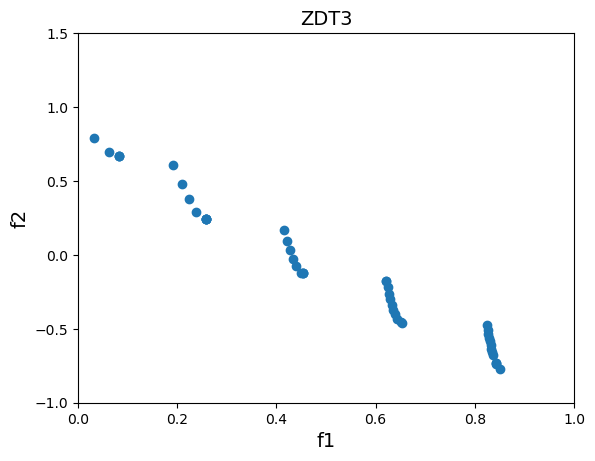

In [86]:
# --- 散布図 ---
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.xlabel("f1", fontsize=14)
plt.ylabel("f2", fontsize=14)
plt.title("ZDT3", fontsize=14)
plt.xlim(0,1)
plt.ylim(-1,1.5)

#plt.scatter(f_values[:, 0], f_values[:, 1])    # 全解
plt.scatter(F[:, 0], F[:, 1])    # 非劣解


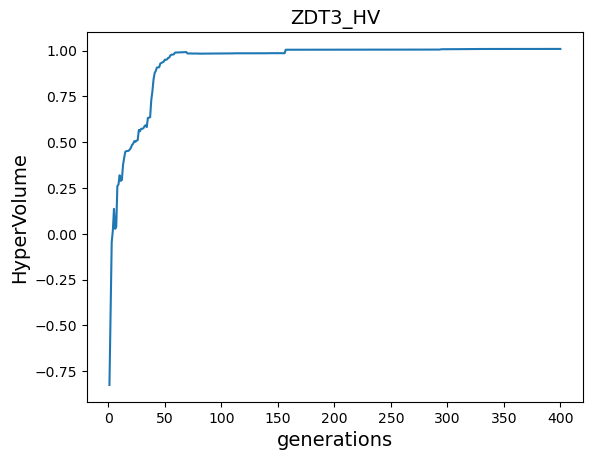

In [87]:
# --- HVと世代数のグラフ---
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.xlabel("generations", fontsize=14)
plt.ylabel("HyperVolume", fontsize=14)
plt.title("ZDT3_HV", fontsize=14)

plt.plot(range(1, len(HV_past)+1), HV_past)
